# LSTM trained model

#### 0. Correr solo en caso de no tener las dependencias

In [94]:
!pip install pandas tensorflow scikit-learn scipy seaborn wordcloud unidecode

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 235.9/235.9 kB 7.1 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


#### 1. Preprocesamiento de datos

Cargar el archivo CSV que contiene los mensajes y las etiquetas de phishing/no-phishing.
Luego tokenizamos los mensajes y los convertimos en una secuencias de numeros que representan las distintas palabras

In [251]:
import pandas as pd

file_path = "dataset_phishing_2023-08-15.csv"
df = pd.read_csv(file_path, sep='\t')

messages = df['message']
is_phishing = df['phishing']

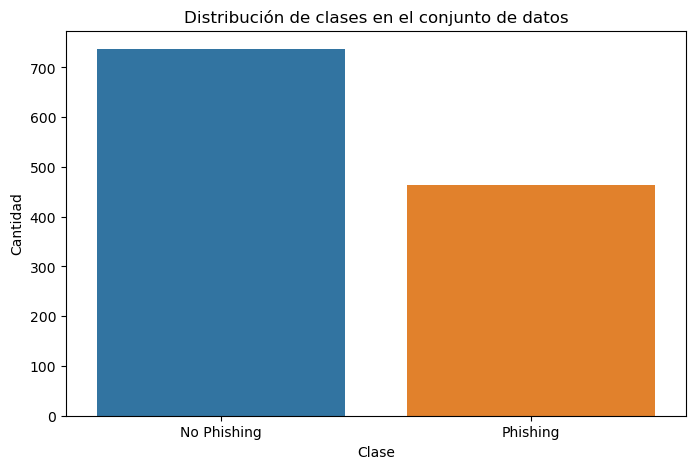

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una columna categórica para representar las etiquetas
df['class'] = df['phishing'].map({0: 'No Phishing', 1: 'Phishing'})

# Gráfico de barras usando seaborn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='class')
plt.title('Distribución de clases en el conjunto de datos')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()


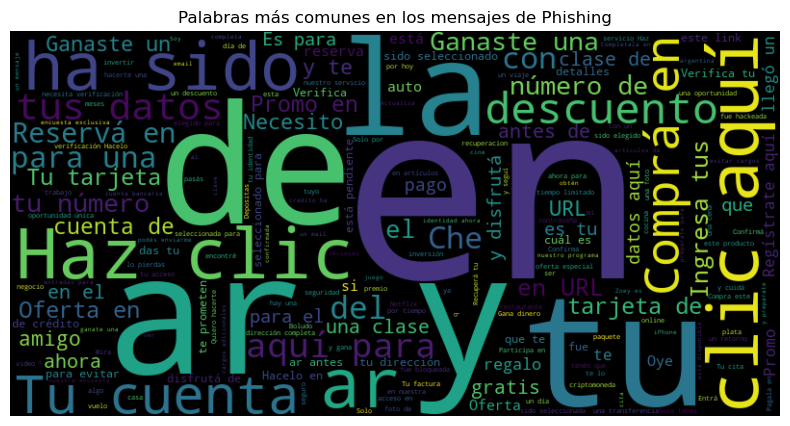

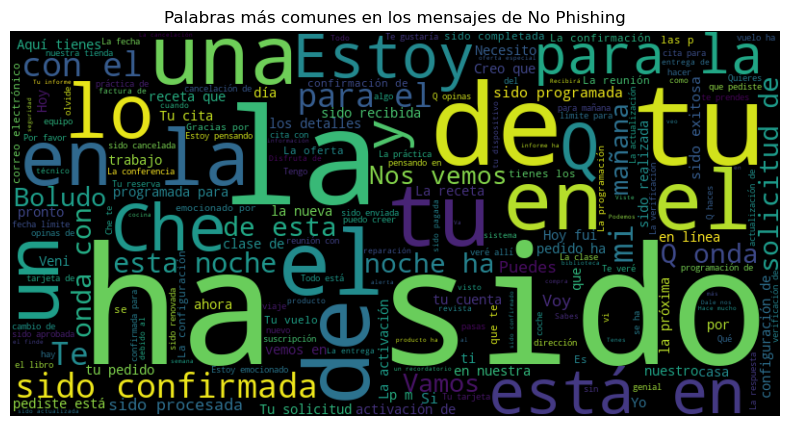

In [275]:
from wordcloud import WordCloud

# Separar los mensajes por clase
phishing_text = ' '.join(df[df['phishing'] == 1]['message'])
non_phishing_text = ' '.join(df[df['phishing'] == 0]['message'])

# Crear y mostrar la nube de palabras para la clase Phishing
phishing_wordcloud = WordCloud(width=800, height=400).generate(phishing_text)
plt.figure(figsize=(10,5))
plt.imshow(phishing_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más comunes en los mensajes de Phishing')
plt.show()

# Crear y mostrar la nube de palabras para la clase No Phishing
non_phishing_wordcloud = WordCloud(width=800, height=400).generate(non_phishing_text)
plt.figure(figsize=(10,5))
plt.imshow(non_phishing_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más comunes en los mensajes de No Phishing')
plt.show()


##### Funciones de pre procesamiento

In [278]:
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('spanish'))
ps = PorterStemmer()

def preprocess_text(text):
    # Reemplazar URLs por un token específico
    text = re.sub(r'http\S+|www\S+', 'URLTOKEN', text)
    # Eliminar acentos
    text = unidecode(text)
    # Convertir a minúscula y eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar palabras vacías y aplicar stemming
    text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

In [279]:
# Tokenización
# Aplicar la función de preprocesamiento a la columna de mensajes
messages = df['message'].apply(preprocess_text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(messages)
sequences = tokenizer.texts_to_sequences(messages)

# Padding
max_length = max([len(sequence) for sequence in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

#### Embedding vectors

Solo habilitado para probar...

In [287]:
from gensim.models import KeyedVectors

# Cambia esto por la ruta a tu archivo de embeddings de FastText
embedding_file = 'cc.es.300.vec'

fasttext_embeddings = KeyedVectors.load_word2vec_format(embedding_file, binary=False)

embedding_dim = 300 # Debe coincidir con la dimensión de los embeddings de FastText

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in fasttext_embeddings:
        embedding_vector = fasttext_embeddings[word]
        embedding_matrix[i] = embedding_vector

#### Graficos de datos

#### 2. Dividir en conjuntos de entrenamiento, validación y prueba

Separaremos los datos en conjuntos de entrenamiento, validación y prueba para entrenar y evaluar nuestro modelo.

In [283]:
from sklearn.model_selection import train_test_split

# Dividir
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, is_phishing, test_size=0.2, random_state=42)

#### 3. Construccion del modelo

Una red neuronal con una capa de incrustación seguida de una capa LSTM y una capa densa para la clasificación.

In [284]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])


In [288]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
27/27 [==============================] - 3s 65ms/step - loss: 0.6371 - accuracy: 0.6250 - val_loss: 0.5156 - val_accuracy: 0.6771
Epoch 2/10
27/27 [==============================] - 1s 32ms/step - loss: 0.4200 - accuracy: 0.8414 - val_loss: 0.3962 - val_accuracy: 0.8229
Epoch 3/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2907 - accuracy: 0.8947 - val_loss: 0.3118 - val_accuracy: 0.8854
Epoch 4/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2059 - accuracy: 0.9306 - val_loss: 0.2807 - val_accuracy: 0.8958
Epoch 5/10
27/27 [==============================] - 1s 32ms/step - loss: 0.1554 - accuracy: 0.9410 - val_loss: 0.2926 - val_accuracy: 0.8854
Epoch 6/10
27/27 [==============================] - 1s 32ms/step - loss: 0.1193 - accuracy: 0.9537 - val_loss: 0.2792 - val_accuracy: 0.8958
Epoch 7/10
27/27 [==============================] - 1s 32ms/step - loss: 0.0874 - accuracy: 0.9688 - val_loss: 0.2388 - val_accuracy: 0.8958
Epoch 8/10
27

#### 4. Evaluacion y analisis

Evaluaremos los datos con metricas para validar y verificar que el modelo haga lo que realmente deba y no este sesgado y sea potente

In [296]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

8/8 [==============================] - 0s 17ms/step - loss: 0.1877 - accuracy: 0.9375
Accuracy: 93.75%


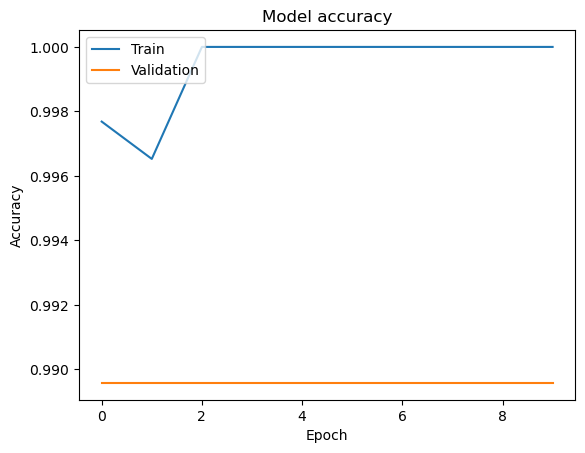

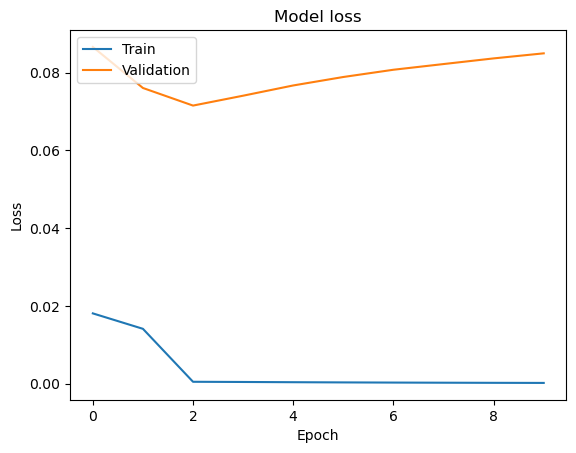

In [289]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Grafico de confusion

8/8 [==============================] - 0s 17ms/step


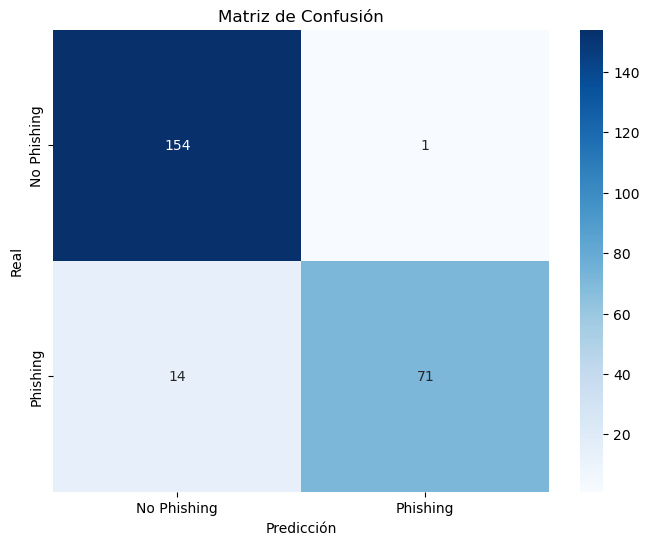

In [290]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype('int32')

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)
# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Phishing', 'Phishing'], yticklabels=['No Phishing', 'Phishing'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


# Testeo manual

In [301]:
# Frase de entrada
input_text = "No, no hagas eso. Yo no necesito el dinero gracias igual"

# Tokenizar y convertir la frase en una secuencia de enteros
input_seq = tokenizer.texts_to_sequences([input_text])

# Rellenar la secuencia para que tenga la misma longitud que los datos de entrenamiento
input_seq_padded = pad_sequences(input_seq, maxlen=max_length)

# Realizar la predicción
predicted_prob = model.predict(input_seq_padded)

# Interpretar la predicción
print(predicted_prob)
predicted_label = 'Phishing' if predicted_prob[0][0] > 0.5 else 'No Phishing'

print(f"La frase es clasificada como: {predicted_label}")


1/1 [==============================] - 0s 18ms/step
[[0.5466868]]
La frase es clasificada como: Phishing
